### Desperately Seeking Silver

We are going to focus on the 2012 Presidential election.

We are going to focus on the 2012 Presidential election. Analysts like Nate Silver, Drew Linzer, and Sam Wang developed highly accurate models that correctly forecasted most or all of the election outcomes in each of the 50 states. We will explore how hard it is to recreate similarly successful models.

Outcomes:

1. To practice data manipulation with Pandas
2. To develop intuition about the interplay of **precision**, **accuracy**, and **bias** when making predictions
3. To better understand how election forecasts are constructed


In [1]:
"""   helper python script that contains the following :

- dark2_colors : a (rgb) color palette
- remove_border
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
- draw_state
    Automatically draws a filled shape representing the state in subplot.
- make_map
    Draw a cloropleth map, that maps data onto the United States
"""
%run hw2.py

In [2]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
from matplotlib.rcsetup import cycler

mpl.rc('figure', figsize=(10,6), dpi=150)
mpl.rc('axes', facecolor='white', 
       prop_cycle=cycler('color', dark2_colors ))
mpl.rc('lines', lw=2)
mpl.rc('patch', ec='white', fc=dark2_colors[0])
mpl.rc('font', size=14, family='StixGeneral')

In [4]:
# We are pretending to build our model 1 month before the election
import datetime
today = datetime.datetime(2012, 10, 2)
today

datetime.datetime(2012, 10, 2, 0, 0)

In [5]:
electoral_votes = pd.read_csv("../data/hw2_data/electoral_votes.csv").set_index('State')
electoral_votes.head()

,Votes
State,
California,55
Texas,38
New York,29
Florida,29
Illinois,20


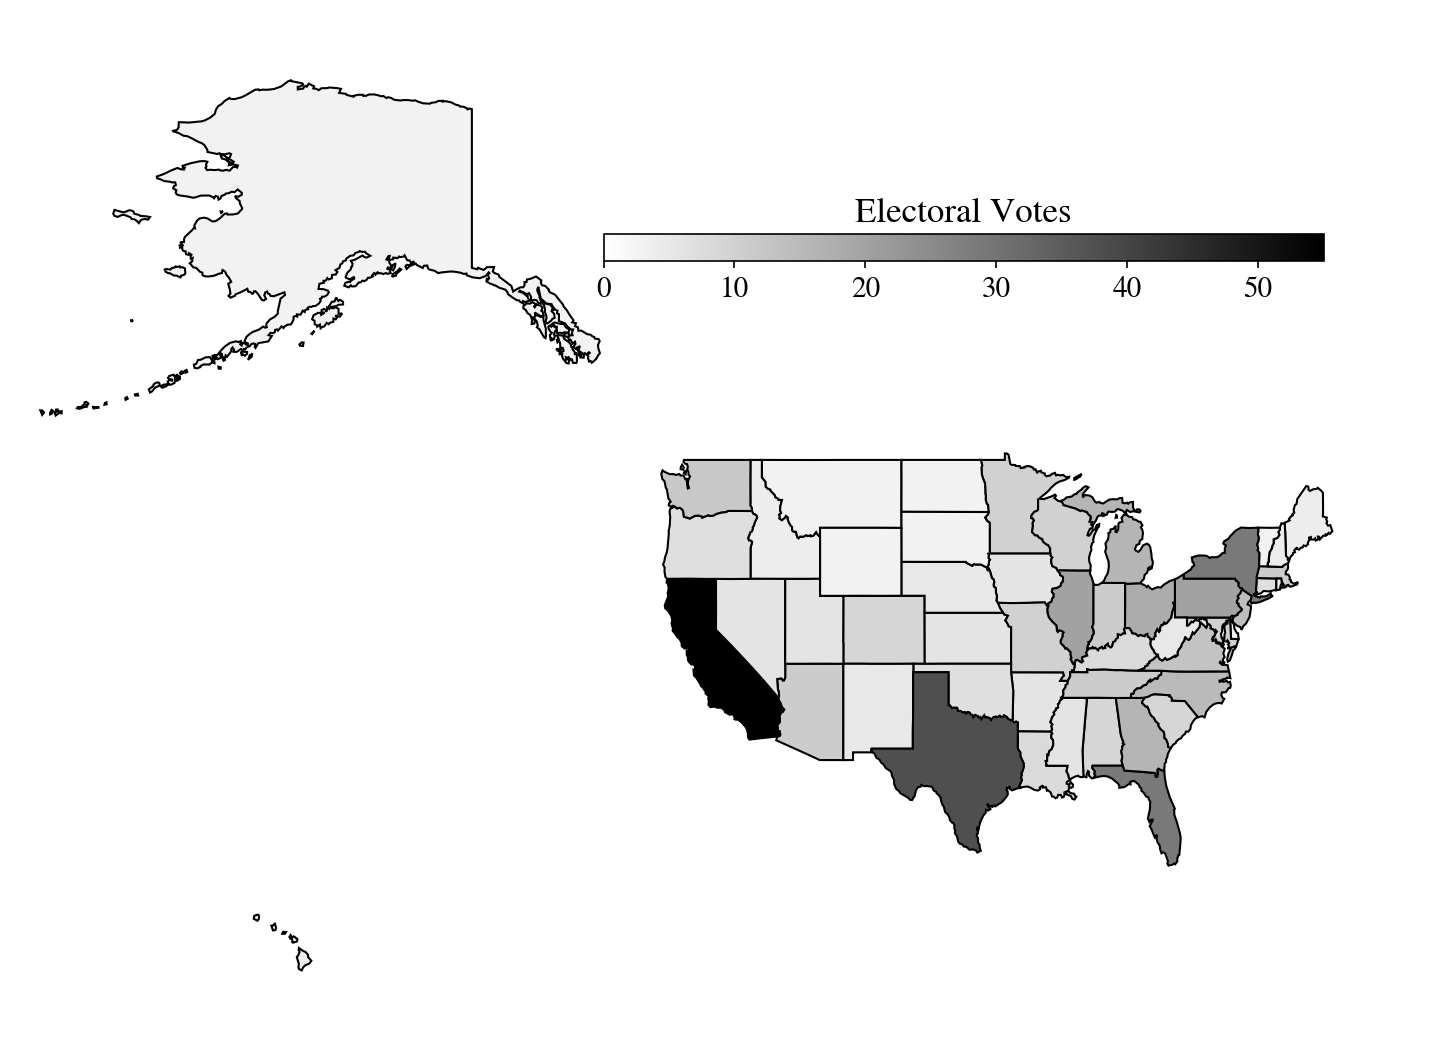

In [6]:
make_map(electoral_votes.Votes, "Electoral Votes")

### Question 1: Simulating elections

Our reference point:
[PredictWise](http://www.predictwise.com/results/2012/president)'s quite successful forecast, released on October 2, 2012.

PredictWise aggregated polling data and, for each state, estimated the probability that the Obama or Romney would win. Here are those estimated probabilities:


In [7]:
predictwise = pd.read_csv('../data/hw2_data/predictwise.csv').set_index('States')
predictwise.head()


,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


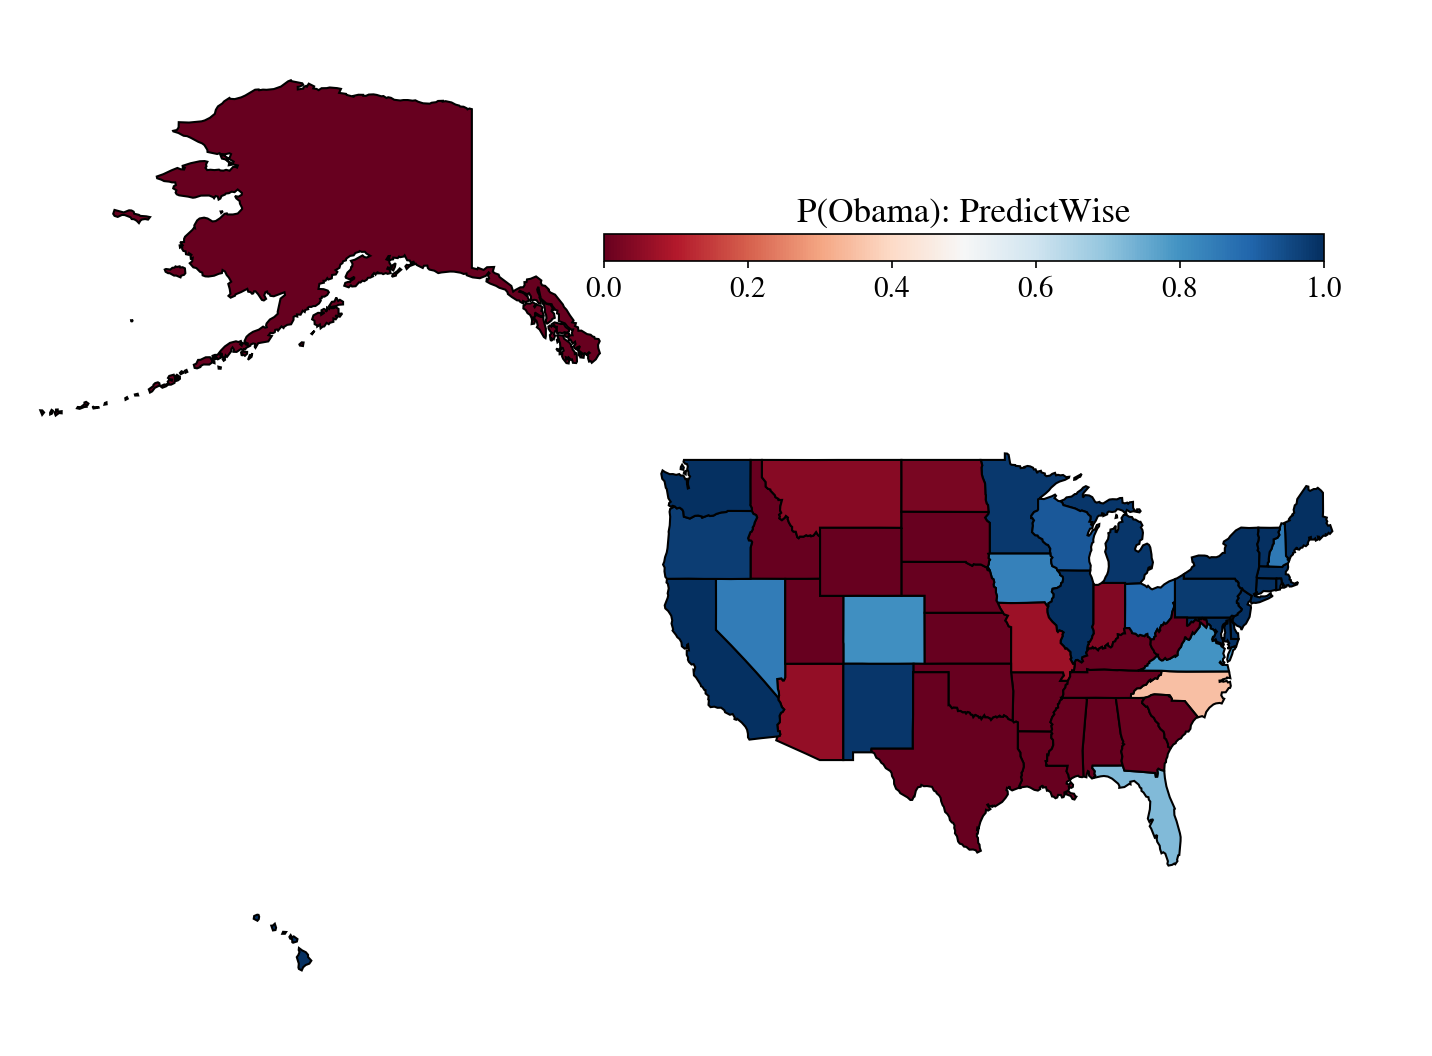

In [8]:
# Using make_map, plot the probability that
# Obama wins each state, according to this prediction.
make_map(predictwise.Obama, "P(Obama): PredictWise")

Even when we assume the win probabilities in each state are known, there is still uncertainty left in the election. We will use simulations from a simple probabilistic model to characterize this uncertainty.

We will assume that the outcome in each state is the result of an independent coin flip whose probability of coming up Obama is given by a Dataframe of state-wise win probabilities.

From these simulations, we will be able to make a prediction about the expected outcome of the election

In [9]:
"""
Function
--------
simulate_election

Inputs
------
model : DataFrame
    A DataFrame summarizing an election forecast. The dataframe has 51 rows -- one for each state and DC
    It has the following columns:
       Obama : Forecasted probability that Obama wins the state
       Votes : Electoral votes for the state
    The DataFrame is indexed by state (i.e., model.index is an array of state names)
    
n_sim : int
   Number of simulations to run
   
Returns
-------
results : Numpy array with n_sim elements
   Each element stores the number of electoral college votes Obama wins in each simulation.   
"""
def simulate_election(model, n_sim):
    # each column simulates a single outcome from the 50 states + DC
    # Obama wins the simulation if 
    # the random number is < the win probability
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < 
                   model.Obama.values.reshape(-1, 1)
                  ) * model.Votes.values.reshape(-1, 1)
    # summing over rows gives the total electoral votes 
    # for each simulation
    return obama_votes.sum(axis=0)


The following cells takes the necessary DataFrame for the Predictwise data, and runs 10000 simulations. 

We use the results to compute the probability, according to this predictive model, that Obama **wins** the election (i.e., the probability that he receives `269 or more` electoral college votes)

In [14]:
result = simulate_election(predictwise, 10000)
result

array([309, 332, 337, ..., 322, 338, 326])

In [16]:
#compute the probability of an Obama win, given this simulation
print((result >= 269).mean())

0.996


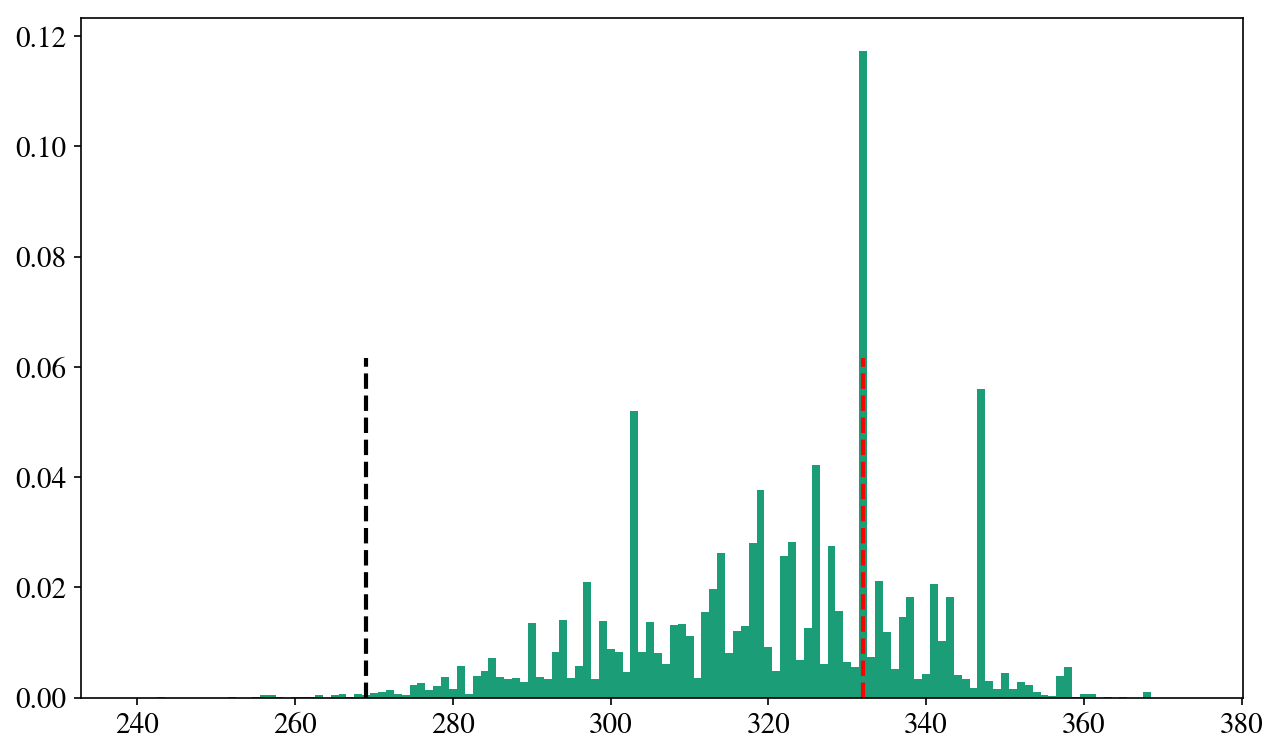

In [33]:
_ = plt.hist(result, bins=np.arange(240, 375, 1), 
             align='left', 
             density=True)
plt.axvline(332, 0, .5, color='r', linestyle='--', label='Actual Outcome')
plt.axvline(269, 0, .5, color='k', linestyle='--', label='Victory Threshold')

In [47]:
"""
Function
--------
plot_simulation

Inputs
------
simulation: Numpy array with n_sim (see simulate_election) elements
   Each element stores the number of electoral college votes 
   Obama wins in each simulation.
"""
def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(240, 375, 1), 
             label='simulations', align='left', density=True)
    plt.axvline(332, 0, .5, color='r', 
                linestyle='--', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', 
                linestyle='--', label='Victory Threshold')
    
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    
    pwin = ((simulation >= 269).mean() * 100)
    
    plt.title("Chance of Obama Victory: {:.1f}%, Spread: {} votes".format(
    pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    remove_border()

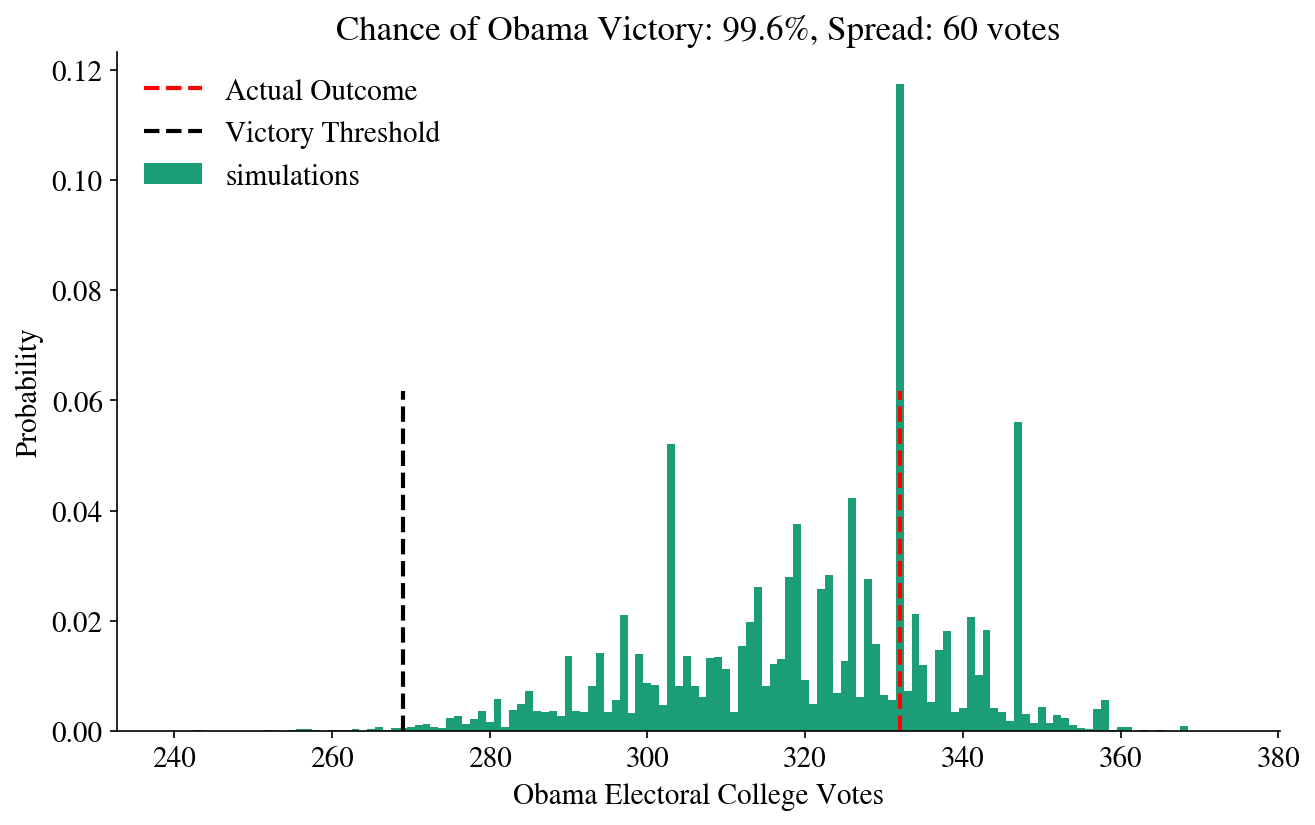

In [48]:
plot_simulation(result)